# 📞 Отток клиентов телеком-компании

Оператору связи необходимо спрогнозировать отток клиентов. Если выяснится, что пользователь собирается уйти, ему будут предложены специальные условия.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

In [1]:
RND = 12345

import time
# import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="ticks")
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)
matplotlib.rcParams['figure.subplot.wspace'] = 0.2
matplotlib.rcParams['figure.subplot.hspace'] = 0.2
from IPython.display import display
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import lightgbm
from sklearn.linear_model import LogisticRegression

from tqdm import tqdm

In [2]:
def missing_values(data, show_plot=True):
    print('Пропущенные значения по признакам:')
    print(data.isna().sum())
    if show_plot == True:
      sns.heatmap(data.isnull(), 
                  cbar = False, 
                  cmap='cividis').set_title("Тепловая карта пропущенных значений")

## Загрузка данных и предпросмотр данных

In [ ]:
contract = pd.read_csv('/content/drive/MyDrive/Yandex/final_project/data/final_provider/contract.csv')
personal = pd.read_csv('/content/drive/MyDrive/Yandex/final_project/data/final_provider/personal.csv')
internet = pd.read_csv('/content/drive/MyDrive/Yandex/final_project/data/final_provider/internet.csv')
phone = pd.read_csv('/content/drive/MyDrive/Yandex/final_project/data/final_provider/phone.csv')

In [4]:
print('contract:')
display(contract.head(3))
contract.info()
contract.describe()

contract:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [5]:
contract[contract['TotalCharges']==' '].head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,


❗ Есть пропуски, представленные пробелом

In [6]:
print('personal:')
display(personal.head(3))
personal.info()

personal:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [7]:
print('internet:')
display(internet.head(3))
internet.info()

internet:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [8]:
print('phone:')
display(phone.head(3))
phone.info()

phone:


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


### 📍 Выводы 
__Файлы загружены и открыты, проведен предварительный просмотр__ <br>
🔍 _После предпросмотра мы можем сказать следующее:_
1. Есть пропуски представленные пробелом.
2. Необходимо привести некоторые признаки к соответствующим классам (`BeginDate`, `TotalCharges`)
3. Необходимо проверить на дубликаты.



---



---


## Предобработка данных

### Обработка пропусков

📝Так как у нас есть пропуски данных методом заполнения пробелом, просмотрим `contract.TotalCharges` на предмет данных пропусков, также просмотрим и другие признаки во всех таблицах типа `object`

In [9]:
print('Пропусков в TotalCharges: ', end='')
contract[contract['TotalCharges'] == ' '].count()[6]
print('Процент от общего количества: ', contract[contract['TotalCharges'] == ' '].count()[6] / len(contract))

Пропусков в TotalCharges: Процент от общего количества:  0.001561834445548772


📝Процент данных с пропусками ничтожен => мужем удалить данные классы

In [10]:
contract = contract[contract['TotalCharges'] != ' ']

In [11]:
for df in [contract, personal, internet, phone]:
  for column in df.columns:
    if df[column].dtype == 'O' and column != 'customerID':
      print(column)
      print(df[column].unique())
      print()

BeginDate
['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '2015-01-01' '2018-11-01' '2015-03-01' '2018-02-01'
 '2016-06-01' '2015-08-01' '2015-11-01' '2014-06-01' '2017-01-01'
 '2015-07-01' '2016-11-01' '2013-11-01' '2014-01-01' '2013-10-01'


📝Исходя из найденных уникальных значений признаков, пропусков больше нет

### Изменение типов данных
Приведем следующие столбцы у необходимым типам:
- `contract.BeginDate` ➡ `datetime`
- `contract.TotalCharges` ➡ `float`

In [12]:
contract['BeginDate_new'] = pd.to_datetime(
    contract['BeginDate'], format='%Y-%m-%d')
contract.drop('BeginDate', axis=1, inplace=True)

In [13]:
contract['TotalCharges'] = contract['TotalCharges'].astype('float64')

In [14]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   EndDate           7032 non-null   object        
 2   Type              7032 non-null   object        
 3   PaperlessBilling  7032 non-null   object        
 4   PaymentMethod     7032 non-null   object        
 5   MonthlyCharges    7032 non-null   float64       
 6   TotalCharges      7032 non-null   float64       
 7   BeginDate_new     7032 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 494.4+ KB


### Проверка на дубликаты

📝 Проверим по полю `customerID`, данный признак, по идее, должен быть уникальным

In [15]:
if len(contract['customerID'].unique()) == len(contract):
  print("Все значения по признаку customerID уникальны")

Все значения по признаку customerID уникальны


### 📍 Выводы
- Обработали пропуски
- Преобразовали данные в нужные типы
- Проверили дубликаты




---



---


## Исследовательский анализ данных и подготовка данных

### Оценка полезности признаков



__Датафрейм `contract`__ <br>


|#  | Column            | Описание действий   
|---|  ------           | --------------       
| 0 |  customerID       | Данный признак нам нужен для соединения таблиц, отбросим его позже
| 1 |  🎯EndDate          | 🎯Это целевой признак, преобразуем его следующим образом: `no` в `0`, что значит клиент не ушел, остальные в `1`
| 2 |  Type             | Преобразуем методом OHE
| 3 |  PaperlessBilling | Преобразуем методом OHE
| 4 |  PaymentMethod    | Преобразуем методом OHE
| 5 |  MonthlyCharges   | Оставим
| 6 |  TotalCharges     | Оставим
| 7 |  BeginDate_new    | Удалим

__Датафрейм `personal`__ <br>

|#  | Column            | Описание действий   
|---|  ------           | --------------       
| 0 |  customerID       | Данный признак нам нужен для соединения таблиц
|1  |gender             | Преобразуем методом OHE
|2  |SeniorCitizen      | Оставим как есть
|3  |Partner            | Преобразуем методом OHE
|4  |Dependents         | Преобразуем методом OHE

__Датафрейм `internet`__ <br>

|#  | Column            | Описание действий   
|---|  ------           | --------------       
| 0 |  customerID       | Данный признак нам нужен для соединения таблиц
|1  | InternetService   | Преобразуем методом OHE
|2  | OnlineSecurity    | Преобразуем методом OHE
|3  | OnlineBackup      | Преобразуем методом OHE
|4  | DeviceProtection  | Преобразуем методом OHE
|5  | TechSupport       | Преобразуем методом OHE
|6  | StreamingTV       | Преобразуем методом OHE
|7  | StreamingMovies   | Преобразуем методом OHE

__Датафрейм `phone`__ <br>

|#  | Column            | Описание действий   
|---|  ------           | --------------       
| 0 |  customerID       | Данный признак нам нужен для соединения таблиц
| 1 |  MultipleLines    | Преобразуем методом OHE

📝 Соединим все датафреймы в 1 и посмотрим общую информацию:

Пропущенные значения по признакам:
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
BeginDate_new          0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1520
OnlineSecurity      1520
OnlineBackup        1520
DeviceProtection    1520
TechSupport         1520
StreamingTV         1520
StreamingMovies     1520
MultipleLines        680
dtype: int64


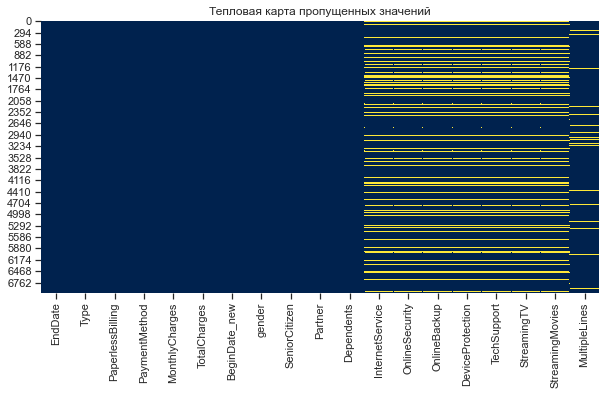

In [16]:
df = contract.merge(personal, on='customerID', how='left')
df = df.merge(internet, on='customerID', how='left')
df = df.merge(phone, on='customerID', how='left')
df = df.drop('customerID', axis=1)
missing_values(df)

📝Как мы видим образовались пропуски в данных, они появились так как кто-то из клиентов не пользуется интернетом или напротив, мобильной связью. <br>
📝Так как данные клинеты не непользуются той или иной услугой (возможности ведения параллельных линий во время звонка), а в целом не оплачивают интернет или моб. связь, то считаю целесообразным заполнить пропуски `No`. И добавить признак `PhoneUsed`, где будет 1 если есть в списке и 0 если не было. <br>
📝Так как `InternetService` - сам факт предоставления доступа в интернет, просто заполним `No`

In [17]:
df['MultipleLines'].fillna('2a2', inplace=True)

In [18]:
def used(data):
  if data == '2a2':
    return 0
  else:
    return 1

df['PhoneUsed'] = df['MultipleLines'].apply(used)

In [19]:
df['MultipleLines'] = df.MultipleLines.apply(lambda x: 'No' if x == '2a2' else x)
df.fillna('No', inplace=True)

In [20]:
# df = df.drop('BeginDate_new', axis=1)

In [21]:
def target_encoder(data):
  if data == 'No':
    return 0
  else:
    return 1

df['user_left'] = df['EndDate'].apply(target_encoder)

In [22]:
df['EndDate'] = df.EndDate.apply(lambda x: '2020-02-01 00:00:00' if x == 'No' else x)
df['EndDate'] = pd.to_datetime(df['EndDate'], format='%Y-%m-%d')

### Статистический аналих данных

#### Анализ `contract.MonthlyCharges`

Text(0.5, 1.0, 'Ежемесячные траты')

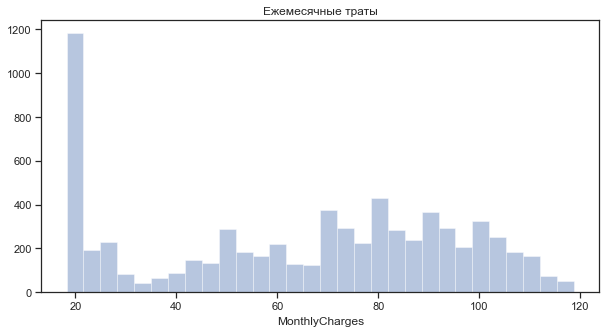

In [23]:
sns.distplot(df['MonthlyCharges'], kde=False, bins=30)
plt.title('Ежемесячные траты')

📝 Как видно из гистограммы, наибольший пик по кол-ву пользователей находится в зоне \~20 у.е. в месяц, также можем выделить еще 2 большие группы, это те, кто тратят 45\~60 у.е. в месяц, и больше \~70. <br>
Построим боксплот, чтобы обработать выбросы

<AxesSubplot:xlabel='MonthlyCharges'>

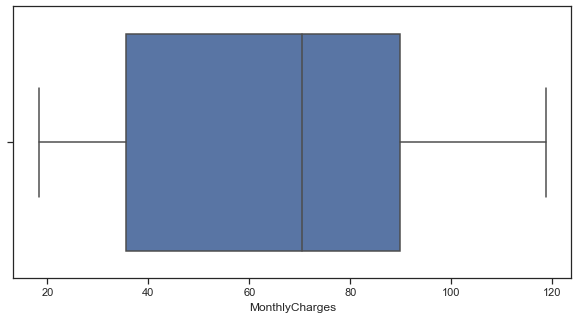

In [24]:
sns.boxplot(df['MonthlyCharges'])

📝Выбросов нет

#### Анализ `contract.TotalCharges`

Text(0.5, 1.0, 'Всего потрачено денег на услуги')

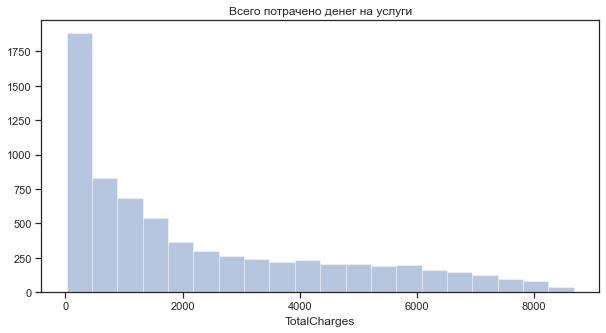

In [25]:
sns.distplot(df['TotalCharges'], kde=False, bins=20)
plt.title('Всего потрачено денег на услуги')

📝На графике мы видим нисходящую тенденцию т.е. то есть люди в основном не тратили относительно большие суммы на услуги, и чем общая сумма больше, тем меньше людей попадают в данную категорию плательщиков

<AxesSubplot:xlabel='TotalCharges'>

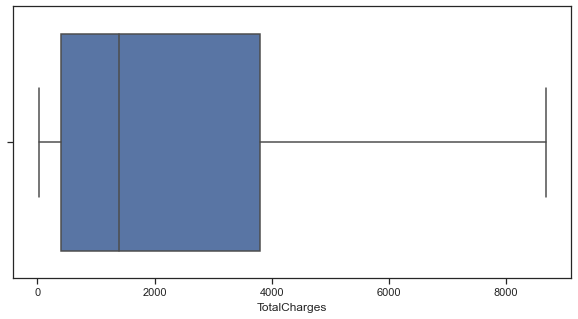

In [26]:
sns.boxplot(df['TotalCharges'])

📝Выбросов нет

**OneHotEncoding**

In [27]:
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe['InternetService_Yes'] = df_ohe['InternetService_Fiber optic'].apply(lambda x: 1 if x == 1 else x)
df_ohe['InternetService_Yes'] = df_ohe['InternetService_No'].apply(lambda x: 1 if x == 0 else 0)
df_ohe.drop('InternetService_No', axis=1, inplace=True)

#### Генерация признаков

__Время с компанией__ <br>
📝 Сколько клиент с компанией. Так как у клиентов все даты от 1-го числа, можно посчитать кол-во месяцев в качестве клиента

In [28]:
df_ohe['Is_Client'] = (df_ohe['EndDate'] - df_ohe['BeginDate_new']).dt.days // 30
df_ohe.drop('EndDate', inplace=True, axis=1)
df_ohe.drop('BeginDate_new', inplace=True, axis=1)

__По количеству подключенных услуг для и-нета__ <br>
📝 Попробуем посмотреть, имеет ли значение, какое общее кол-во услуг для инетрнета имеет клиент <br>
Признаки интернет сервисов:
`InternetService `,
`OnlineSecurity  `,
`OnlineBackup    `,
`DeviceProtection`,
`TechSupport     `,
`StreamingTV     `,
`StreamingMovies `

In [29]:
df_ohe['count_int_ser'] = df_ohe[df_ohe[['InternetService_Yes',
                                         'OnlineSecurity_Yes', 
                                         'OnlineBackup_Yes', 
                                         'DeviceProtection_Yes',
                                         'TechSupport_Yes',
                                         'StreamingTV_Yes',
                                         'StreamingMovies_Yes']] == 1].sum(axis=1)
df_ohe['count_int_ser'] = df_ohe['count_int_ser'].astype('int64')

Text(0.5, 0, 'Кол-во подключенных услуг')

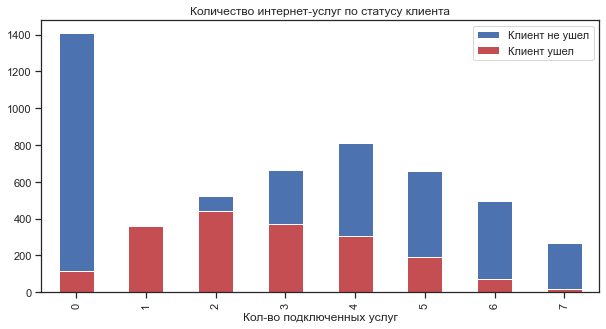

In [30]:
x = df_ohe[df_ohe['user_left'] == 1].groupby(by='count_int_ser').count()['user_left']
y = df_ohe[df_ohe['user_left'] == 0].groupby(by='count_int_ser').count()['user_left']
y.plot.bar()
x.plot.bar(color='r')
plt.legend(['Клиент не ушел', 'Клиент ушел'])
plt.title('Количество интернет-услуг по статусу клиента')
plt.xlabel('Кол-во подключенных услуг')

Видим, что некая зависимость есть: <br>
- Люди, которые не использую интернет вообще, чаще остаются с компанией
- Люди, которые подключили интренет без доп услуг (1 подключенная услуга), часто уходят
- Чем больше услуг подключено, тем меньше отток

In [31]:
df_ohe.drop('Partner_Yes', inplace=True, axis=1)
df_ohe.drop('gender_Male', inplace=True, axis=1)
df_ohe.drop('Dependents_Yes', inplace=True, axis=1)

---

#### Корреляция колличественных признаков

Text(0.5, 1.0, 'Тепловая карта корреляции по Пирсону')

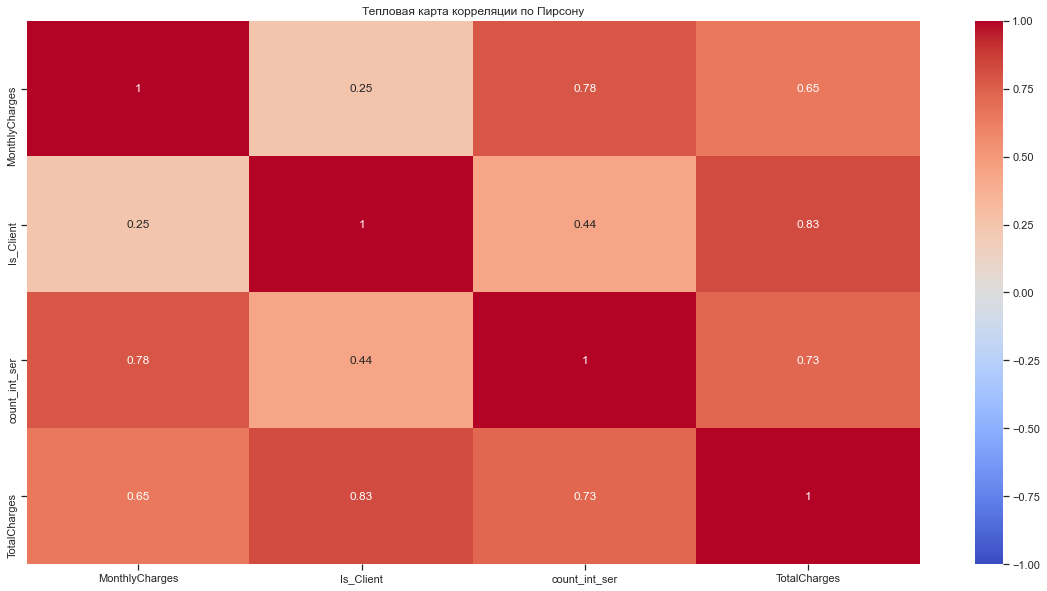

In [32]:
numeric = ['MonthlyCharges', 'Is_Client', 'count_int_ser', 'TotalCharges']

plt.figure(figsize=(20, 10))
sns.heatmap(df_ohe[numeric].corr(),
            cmap='coolwarm',
            vmin=-1, vmax=1,
            annot=True)
plt.title('Тепловая карта корреляции по Пирсону')

In [33]:
df_ohe.drop('TotalCharges', axis=1, inplace=True)
numeric.remove('TotalCharges')

#### Разбиение на выборки
📝 Данные будем разбивать на три выборки: <br>
- обучающую выборку - 60%
- валидационную выборку - 20%
- тестовую выборку - 20%

In [34]:
df_train, df_others = train_test_split(df_ohe, test_size=0.4, random_state=RND)
df_test, df_valid = train_test_split(df_others, test_size=0.5, random_state=RND)
print('Общий размер df:', df_ohe.shape)
print('Размер обучающая выборки:', df_train.shape)
print('Размер валидационной выборки:', df_valid.shape)
print('Размер тестовой выборки:', df_test.shape)

Общий размер df: (7032, 21)
Размер обучающая выборки: (4219, 21)
Размер валидационной выборки: (1407, 21)
Размер тестовой выборки: (1406, 21)


#### Сбалансированность классов

Text(0.5, 1.0, 'Соотношение ушедших к оставшимся')

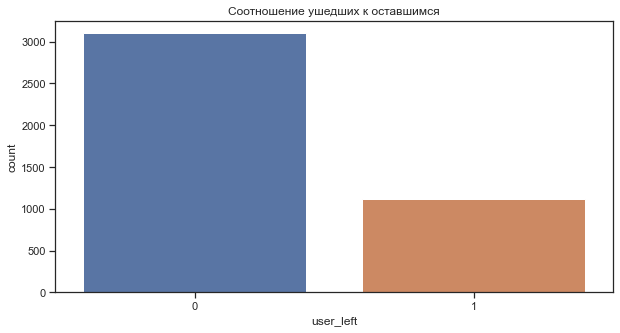

In [35]:
sns.countplot(x='user_left', data=df_train)
plt.title('Соотношение ушедших к оставшимся')

📝Как видно из гистограммы, количество ушедших людей меньше. Сбалансируем классы

Text(0.5, 1.0, 'Соотношение ушедших к оставшимся')

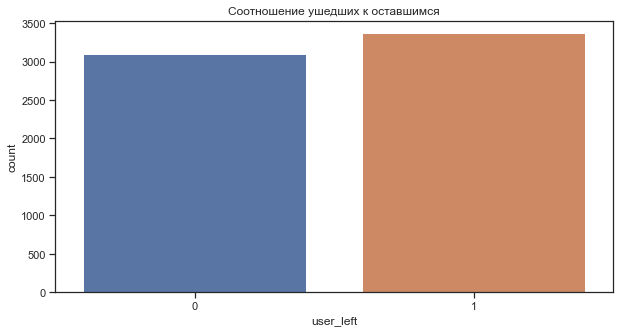

In [36]:
zeros = df_train[df_train['user_left'] == 0]
ones = df_train[df_train['user_left'] == 1]

repead = 3
df_train = pd.concat([zeros] + [ones] * repead)
sns.countplot(x='user_left', data=df_train)
plt.title('Соотношение ушедших к оставшимся')

📝 Разобъем по переменным признаки и целевые признаки

In [37]:
#   Обучающая выборка
features_train = df_train.drop(['user_left'], axis=1)
target_train = df_train['user_left']

#   Валидационная выборка
features_valid = df_valid.drop(['user_left'], axis=1)
target_valid = df_valid['user_left']

#   Тестовая выборка
features_test = df_test.drop(['user_left'], axis=1)
target_test = df_test['user_left']

#### Масштабирование признаков
📝 Произведем масштабирование численных признаков датафрейма

In [38]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

### 📍 Выводы
- Оценили полезносит признаков, отбросили неинтересные нам для обучения
- Провели статистический анализ данных, выбросов не обнаружили
- Сбалансировали классы, так как целевые признаки были не сбалансированны по количеству
- Закодировали категориальные признаки
- Посмотрели корреляцию признаков между собой
- Разбили на выборки
- Отмасштабировали признаки



---



---


## Обучение моделей lightGBM

### Приведем категориальные признаки
📝 так как данная модель чувствительна к категориальным признакам

In [39]:
categorial = list(features_train.columns)
categorial.remove('MonthlyCharges')
# categorial.remove('TotalCharges')
categorial.remove('Is_Client')
categorial.remove('count_int_ser')

features_train[categorial] = features_train[categorial].astype('category')
features_valid[categorial] = features_valid[categorial].astype('category')
features_test[categorial] = features_test[categorial].astype('category')


### Обучение модели
📝Обучение будем производить с подбором гиперпараметров: 
- `max_depth` в промежутке [14, 16] с шагом 1,
- `n_estimators` в промежутке [400, 430] с шагом 1

In [40]:
depth_list = []
est_list = []
result_list = []

for est in tqdm(range(100, 250, 20)):
    for depth in range(1, 25, 2):
        lgbm = lightgbm.LGBMClassifier(silent=True, 
                                       categorical_feature=categorial,
                                       max_depth=depth,
                                       n_estimators=est,
                                       class_weight='balanced')
        lgbm.fit(features_train, target_train)
        predictions_proba = lgbm.predict_proba(features_valid)[:, 1]
        depth_list.append(depth)
        est_list.append(est)
        result_list.append(roc_auc_score(target_valid, predictions_proba))


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:22<00:00,  2.77s/it]


In [41]:
results = pd.DataFrame({
    'max_depth': depth_list,
    'n_estimators': est_list,
    'roc': result_list
})
display(results.sort_values(by='roc', ascending=False).head())

,max_depth,n_estimators,roc
48,1,180,0.839166
84,1,240,0.839075
72,1,220,0.839001
36,1,160,0.838659
60,1,200,0.838562


📝Таким образом, на валидационной выборке, лучшим результатом оказалась модель с гиперпараметрами:
- `max_depth` = 1
- `n_estimators` = 180

### Тестирование модели

In [42]:
depth =1
est = 180
lgbm = lightgbm.LGBMClassifier(silent=True, 
                                   categorical_feature=categorial,
                                   max_depth=depth,
                                   n_estimators=est)
lgbm.fit(features_train, target_train)

LGBMClassifier(categorical_feature=['SeniorCitizen', 'PhoneUsed',
                                    'Type_One year', 'Type_Two year',
                                    'PaperlessBilling_Yes',
                                    'PaymentMethod_Credit card (automatic)',
                                    'PaymentMethod_Electronic check',
                                    'PaymentMethod_Mailed check',
                                    'InternetService_Fiber optic',
                                    'OnlineSecurity_Yes', 'OnlineBackup_Yes',
                                    'DeviceProtection_Yes', 'TechSupport_Yes',
                                    'StreamingTV_Yes', 'StreamingMovies_Yes',
                                    'MultipleLines_Yes',
                                    'InternetService_Yes'],
               max_depth=1, n_estimators=180)

In [43]:
print('📌==================================================📌')

test_predictions = lgbm.predict_proba(features_test)[:, 1]
test_roc_auc = roc_auc_score(target_test, test_predictions)
print('max_depth = {}\nn_estimators = {}\nМетрика roc_auc = {}'.format(depth, est, test_roc_auc))
print('📌==================================================📌')

📌==================================================📌
max_depth = 1
n_estimators = 180
Метрика roc_auc = 0.8572819803970848
📌==================================================📌


<Figure size 720x360 with 0 Axes>

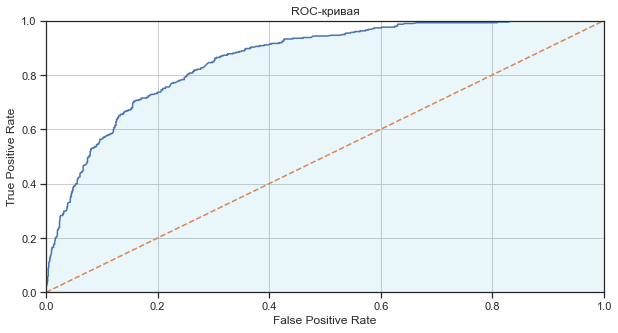

In [44]:
probabilities_test = lgbm.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 

plt.figure()

plt.figure()
plt.plot(fpr, tpr)
plt.fill_between(fpr, tpr, color='#2dbad2', alpha=0.1)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.grid()
plt.show() 

✅ Построенная нами модель достаточно хорошо себя показала в __AUC-ROC = 0.8572819803970848__.

<a id="a2"></a>
### Определение важности факторов

📝 Так как мы будем использовать для обучения __LightGBM__, воспользуемся `lightgbm.plot_importance()`

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

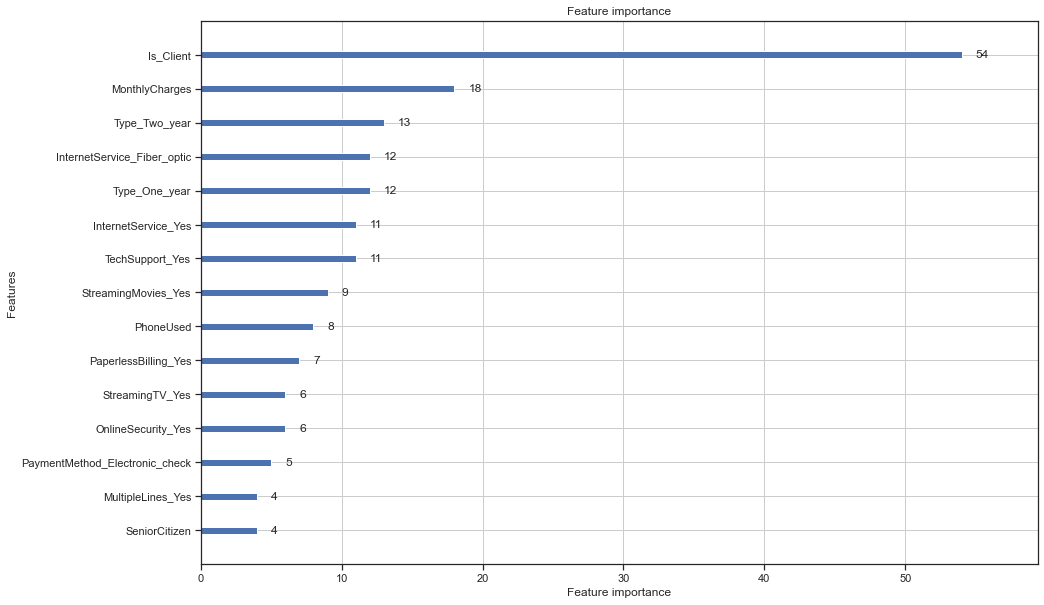

In [45]:
lightgbm.plot_importance(lgbm,
                         figsize=(15, 10))

💡 Основные сведения беруться из затрат клиентов на услуги =)

## 🏁 Выводы
__Цель проекта достигнута.__ Удалось построить такую модель метрика AUC-ROC которой на тестовой выборке =  0.8572819803970848. (max_depth = 1, n_estimators = 180). <br>
_Для этого было сделано следующее:_
- осуществлена предобработка и подготовка данных (кодирование категориальных признаков, разбивка DF на выборки (обучающая, валидационная, тестовая) и признаки/целевые признаки и масштабирование колличественных данных)
- проведено исследование данных
- проведено увеличение выборки методом upsampling
- проведено масштабирование количественных данных
- подбраны гиперпараметры для модели классификации LightGBM
- построена ROC-кривая